# Simple Autoencoder using TensorFlow library

In this notebook I'll build a simple autoencoder to compress the MNIST dataset using TensorFlow 1.15. Autoencoder consist of two fully connected layers. One for encoder and another one for decoder.

In [1]:
# Import required packages

import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# Load the data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
batch_size = 64
latent_space = 128
learning_rate = 0.1
image_size = 28 * 28

n_epochs = 100

In [4]:
# Let's define weights and bias values for the model

ae_weights = {
    "encoder_weights": tf.Variable(
        tf.truncated_normal([image_size, latent_space], stddev=0.1)),
    "encoder_bias": tf.Variable(
        tf.truncated_normal([latent_space], stddev=0.1)),
    "decoder_weights": tf.Variable(
        tf.truncated_normal([latent_space, image_size], stddev=0.1)),
    "decoder_bias": tf.Variable(
        tf.truncated_normal([image_size], stddev=0.1))
}

In [5]:
# Computation graph
ae_input = tf.placeholder(tf.float32, [batch_size, 784])

hidden = tf.nn.sigmoid(tf.matmul(ae_input, ae_weights["encoder_weights"]) + ae_weights["encoder_bias"])

visible_logits = tf.matmul(hidden, ae_weights["decoder_weights"]) + ae_weights["decoder_bias"]

visible = tf.nn.sigmoid(visible_logits)

In [6]:
ae_cost = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=visible_logits, labels=ae_input))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
optimizer = tf.train.AdagradOptimizer(learning_rate)

ae_op = optimizer.minimize(ae_cost)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
n_batches = mnist.train.num_examples // batch_size

In [9]:
original_images, _ = mnist.test.next_batch(batch_size)

In [65]:
def train(op, cost, visible, n_epochs = 100):
    training_losses = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for epoch in range(1, n_epochs + 1):
        
            print(f"Epoch {epoch}/{n_epochs}")
        
            current_training_loss = 0
            step = 0
        
            for batch in range(n_batches):
                x_batch, _ = mnist.train.next_batch(batch_size)
            
                step += 1
            
                _, loss = sess.run([op, cost], feed_dict={ae_input: x_batch})
                current_training_loss += loss
            
                sys.stdout.write(f"\r\tDone: {step / n_batches * 100:0.1f}%, Loss: {(current_training_loss / step):2.4f}")
        
            training_losses.append(current_training_loss / n_batches)
        
            print()

        result = sess.run(visible, feed_dict={ae_input: original_images})
        
    return result, training_losses

In [11]:
result_images, losses = train(ae_op, ae_cost, visible)

Epoch 1/100
	Done: 100.0%, Loss: 0.3605
Epoch 2/100
	Done: 100.0%, Loss: 0.2710
Epoch 3/100
	Done: 100.0%, Loss: 0.2646
Epoch 4/100
	Done: 100.0%, Loss: 0.2607
Epoch 5/100
	Done: 100.0%, Loss: 0.2568
Epoch 6/100
	Done: 100.0%, Loss: 0.2526
Epoch 7/100
	Done: 100.0%, Loss: 0.2481
Epoch 8/100
	Done: 100.0%, Loss: 0.2434
Epoch 9/100
	Done: 100.0%, Loss: 0.2388
Epoch 10/100
	Done: 100.0%, Loss: 0.2342
Epoch 11/100
	Done: 100.0%, Loss: 0.2299
Epoch 12/100
	Done: 100.0%, Loss: 0.2258
Epoch 13/100
	Done: 100.0%, Loss: 0.2220
Epoch 14/100
	Done: 100.0%, Loss: 0.2185
Epoch 15/100
	Done: 100.0%, Loss: 0.2153
Epoch 16/100
	Done: 100.0%, Loss: 0.2122
Epoch 17/100
	Done: 100.0%, Loss: 0.2093
Epoch 18/100
	Done: 100.0%, Loss: 0.2066
Epoch 19/100
	Done: 100.0%, Loss: 0.2042
Epoch 20/100
	Done: 100.0%, Loss: 0.2019
Epoch 21/100
	Done: 100.0%, Loss: 0.1996
Epoch 22/100
	Done: 100.0%, Loss: 0.1976
Epoch 23/100
	Done: 100.0%, Loss: 0.1956
Epoch 24/100
	Done: 100.0%, Loss: 0.1938
Epoch 25/100
	Done: 100.0

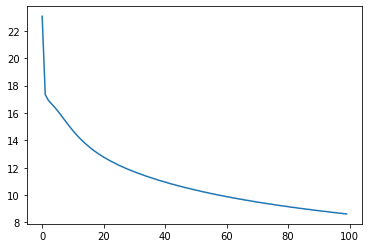

In [12]:
# Let's check how training loss looks
plt.plot(losses)

In [13]:
def plot_imgs(original_images, result_images):
    # Plot the first ten input images and ten reconstructed images
    # Input images on top, reconstructed on bottom
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

    for images, row in zip([original_images, result_images], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape(-1, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)        

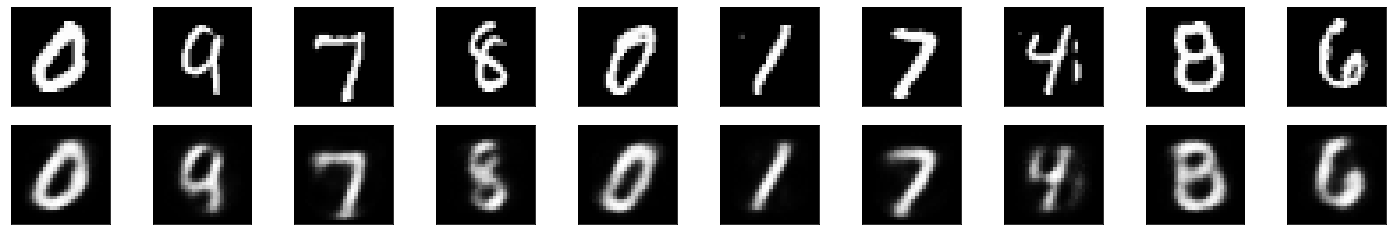

In [14]:
plot_imgs(original_images, result_images)

In [15]:
# Let's add regularization

rho = 0.05
beta = 1.0

data_rho = tf.reduce_mean(hidden, 0)
reg_cost = - tf.reduce_mean(tf.log(data_rho / rho) * rho + tf.log((1 - data_rho) / (1-rho)) * (1 - rho))

total_cost = ae_cost + beta * reg_cost

In [16]:
rae_op = optimizer.minimize(total_cost)

result_images, losses = train(rae_op, total_cost, visible, n_epochs=500)

Epoch 1/500
	Done: 100.0%, Loss: 0.6592
Epoch 2/500
	Done: 100.0%, Loss: 0.5354
Epoch 3/500
	Done: 100.0%, Loss: 0.4628
Epoch 4/500
	Done: 100.0%, Loss: 0.4213
Epoch 5/500
	Done: 100.0%, Loss: 0.3954
Epoch 6/500
	Done: 100.0%, Loss: 0.3773
Epoch 7/500
	Done: 100.0%, Loss: 0.3636
Epoch 8/500
	Done: 100.0%, Loss: 0.3526
Epoch 9/500
	Done: 100.0%, Loss: 0.3434
Epoch 10/500
	Done: 100.0%, Loss: 0.3355
Epoch 11/500
	Done: 100.0%, Loss: 0.3284
Epoch 12/500
	Done: 100.0%, Loss: 0.3223
Epoch 13/500
	Done: 100.0%, Loss: 0.3165
Epoch 14/500
	Done: 100.0%, Loss: 0.3114
Epoch 15/500
	Done: 100.0%, Loss: 0.3066
Epoch 16/500
	Done: 100.0%, Loss: 0.3023
Epoch 17/500
	Done: 100.0%, Loss: 0.2981
Epoch 18/500
	Done: 100.0%, Loss: 0.2942
Epoch 19/500
	Done: 100.0%, Loss: 0.2908
Epoch 20/500
	Done: 100.0%, Loss: 0.2874
Epoch 21/500
	Done: 100.0%, Loss: 0.2842
Epoch 22/500
	Done: 100.0%, Loss: 0.2814
Epoch 23/500
	Done: 100.0%, Loss: 0.2784
Epoch 24/500
	Done: 100.0%, Loss: 0.2759
Epoch 25/500
	Done: 100.0

	Done: 100.0%, Loss: 0.1467
Epoch 394/500
	Done: 100.0%, Loss: 0.1467
Epoch 395/500
	Done: 100.0%, Loss: 0.1465
Epoch 396/500
	Done: 100.0%, Loss: 0.1464
Epoch 397/500
	Done: 100.0%, Loss: 0.1462
Epoch 398/500
	Done: 100.0%, Loss: 0.1463
Epoch 399/500
	Done: 100.0%, Loss: 0.1464
Epoch 400/500
	Done: 100.0%, Loss: 0.1460
Epoch 401/500
	Done: 100.0%, Loss: 0.1461
Epoch 402/500
	Done: 100.0%, Loss: 0.1461
Epoch 403/500
	Done: 100.0%, Loss: 0.1457
Epoch 404/500
	Done: 100.0%, Loss: 0.1457
Epoch 405/500
	Done: 100.0%, Loss: 0.1460
Epoch 406/500
	Done: 100.0%, Loss: 0.1453
Epoch 407/500
	Done: 100.0%, Loss: 0.1456
Epoch 408/500
	Done: 100.0%, Loss: 0.1453
Epoch 409/500
	Done: 100.0%, Loss: 0.1455
Epoch 410/500
	Done: 100.0%, Loss: 0.1453
Epoch 411/500
	Done: 100.0%, Loss: 0.1453
Epoch 412/500
	Done: 100.0%, Loss: 0.1451
Epoch 413/500
	Done: 100.0%, Loss: 0.1451
Epoch 414/500
	Done: 100.0%, Loss: 0.1449
Epoch 415/500
	Done: 100.0%, Loss: 0.1450
Epoch 416/500
	Done: 100.0%, Loss: 0.1447
Epoch 

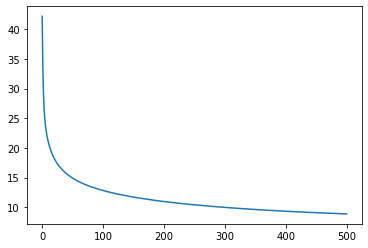

In [17]:
plt.plot(losses)

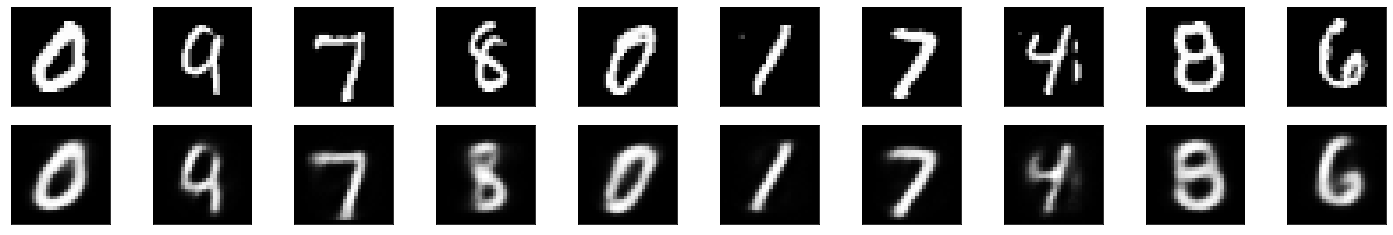

In [18]:
plot_imgs(original_images, result_images)

In [66]:
# Computation graph
ae_input = tf.placeholder(tf.float32, [batch_size, 784])

hidden_relu = tf.nn.leaky_relu(
    tf.matmul(ae_input, ae_weights["encoder_weights"]) + ae_weights["encoder_bias"])

visible_relu = tf.nn.sigmoid(
    tf.matmul(hidden_relu, ae_weights["decoder_weights"]) + ae_weights["decoder_bias"])

In [67]:
ae_cost_relu = tf.reduce_mean(
    tf.squared_difference(visible_relu, ae_input))

optimizer_adam = tf.train.AdamOptimizer()

ae_op_relu = optimizer_adam.minimize(ae_cost_relu)

result_images, losses = train(ae_op_relu, ae_cost_relu, visible_relu, n_epochs=10)

Epoch 1/10
	Done: 100.0%, Loss: 0.0269
Epoch 2/10
	Done: 100.0%, Loss: 0.0066
Epoch 3/10
	Done: 100.0%, Loss: 0.0040
Epoch 4/10
	Done: 100.0%, Loss: 0.0032
Epoch 5/10
	Done: 100.0%, Loss: 0.0027
Epoch 6/10
	Done: 100.0%, Loss: 0.0024
Epoch 7/10
	Done: 100.0%, Loss: 0.0023
Epoch 8/10
	Done: 100.0%, Loss: 0.0021
Epoch 9/10
	Done: 100.0%, Loss: 0.0020
Epoch 10/10
	Done: 100.0%, Loss: 0.0019


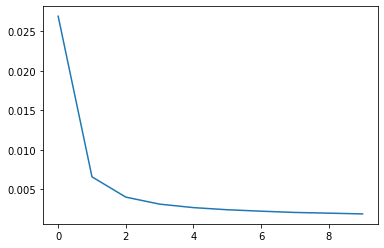

In [68]:
plt.plot(losses)

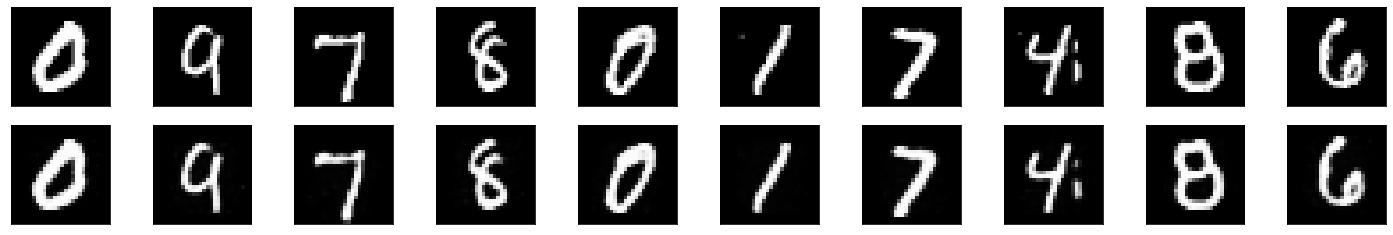

In [69]:
plot_imgs(original_images, result_images)